In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(style="whitegrid") 

import statsmodels.api         as sm
import statsmodels.formula.api as smf
from scipy import stats
import scipy

from patsy import dmatrices
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip

In [2]:
PQR_Date_columns_format = {'fecha_radicacion': '%d/%m/%Y', # Darle el strftime correcto a estas columnas para leerlas como fechas
                    'fecha_vencimiento': '%d/%m/%Y',
                    'fecha_respuesta': '%d/%m/%Y',
                    'created_at': '%Y-%m-%d %H:%M:%S.%f', 
                    'updated_at': '%Y-%m-%d %H:%M:%S.%f' 
                   } 

# Read data from .csv files 
# (this NoteBook works by reading data from local .csv files. For the dashboard app this code was adaptaded to read the data from a SQL database)
PQR_data1 = pd.read_csv('Data/Modulo_PQR_Sector_Salud.csv', sep=';',encoding='latin-1',
                           parse_dates = list(PQR_Date_columns_format.keys())).set_index('id', drop=True)# error_bad_lines=False, warn_bad_lines=True)

PQR_data2 = pd.read_csv('Data/Modulo_PQR_Sector_Salud_V2.csv', sep=';',encoding='latin-1',
                           parse_dates = list(PQR_Date_columns_format.keys())).set_index('id', drop=True)# error_bad_lines=False, warn_bad_lines=True)

# coneccion=conectarse()
# conn=coneccion[1]
# PQR_data = sqlio.read_sql_query("SELECT * FROM MODULO_PQR;", conn, # Leer la tabla MODULO_PQR de la base de datos en SQL
#                                 parse_dates = PQR_Date_columns_format)[1:].reset_index(drop = True)   # Parse_dates para leerlas en formato datetime
#                                                     # exclude row 0 because is the column names repeated

PQR_data1.head(3)

,glb_estado_id,glb_dependencia_id,pqr_medio_peticion_id,pqr_tipo_derechos_id,pqr_tipo_documento_id,glb_tipo_genero_id,ase_tipo_poblacion_id,ase_tipo_regimen_id,pqr_tipo_solicitud_id,pqr_tipo_solicitud_especifica_id,...,d_glb_zona_id,d_glb_barrio_vereda_id,d_direccion,d_telefono_fijo,d_telefono_movil,d_email,asunto,observacion,created_at,updated_at
id,,,,,,,,,,,,,,,,,,,,,
1,3,131,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ACTIVIDADES MASIVAS GENERADAS EN LAS FIESTAS D...,NaN,2022-02-24 22:28:21,2022-03-06 12:20:27
2,4,132,1,1.0,NaN,NaN,0.0,2.0,4.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,SOLICITUD AFILIACION OFICIOSA,NaN,2022-02-24 22:28:21,2022-03-22 11:34:24
3,4,132,1,1.0,NaN,NaN,0.0,2.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"SOLICITUD APOYO PARA ENTREGA DE MEDICAMENTOS ,...",NaN,2022-02-24 22:28:21,2022-03-06 12:20:27


In [3]:
# Merge both dataframes to built the total dataset
PQR_data1 = PQR_data1[~PQR_data1.index.isin(PQR_data2.index)]
PQR_data = pd.concat([PQR_data2,PQR_data1], axis=0).sort_index()

PQR_data.dropna(axis=1, how='all', inplace =True) # drop all the empty columns

In [4]:
# PQR_data.to_csv('Modulo_PQR_Sector_Salud_V3.csv',sep=';')

In [5]:
# Variables considered useful for the model 
columns_model = ['fecha_radicacion',
                 'glb_dependencia_id',
                 'pqr_tipo_derechos_id',
                 'ase_tipo_poblacion_id',
                 'pqr_tipo_solicitud_especifica_id',
                 'glb_entidad_id',
                 'fecha_vencimiento',
                 'fecha_respuesta',
                 'glb_tipo_genero_id',
                 'ase_tipo_regimen_id',
                 'glb_zona_id'
                  ]


In [6]:
df_model = PQR_data[columns_model]

### Data Cleaning

In [7]:
# Drop the rows where there are nan.
df_model = df_model[df_model.fecha_respuesta.notna()].dropna(thresh = 7)

In [8]:
### Set id_genero = 2 (women) when primer_nombre ends with 'A'
# PQR_data.glb_tipo_genero_id[ PQR_data.primer_nombre.str.endswith('A') & ~ PQR_data.primer_nombre.isna() & PQR_data.glb_tipo_genero_id.isna() ] = 2

### Create columns with days between "fecha_radicado" and "fecha_vencimiento"
df_model['plazo_respuesta'] = (df_model.fecha_vencimiento - df_model.fecha_radicacion).dt.days

### Create columns with days between "fecha_radicado" and "fecha_respuesta"
df_model['tiempo_respuesta'] = (df_model.fecha_respuesta - df_model.fecha_radicacion).dt.days
#df_model['tiempo_respuesta'] = (df_model.fecha_vencimiento - df_model.fecha_respuesta).dt.days

df_model.drop(['fecha_radicacion','fecha_respuesta','fecha_vencimiento'], axis=1, inplace =True)
# Delete data where tiempo_respuesta is negative (corrupte data)
df_model = df_model[df_model.tiempo_respuesta>=0]

In [9]:
df_model.plazo_respuesta[df_model.plazo_respuesta>500] = 180 #180 # When Plazo_respuesta is 10.000 days, put it as 180 days
# df_model.tiempo_respuesta[df_model.tiempo_respuesta>500] = np.nan #180 # When Plazo_respuesta is 10.000 days, put it as 180 days


# Create a column of category for plazo where:
# plazo < 100: 0
# plazo between 100 and 180: 1
# plazo = 180: 2
df_model['plazo_categoria'] = df_model.plazo_respuesta.apply(lambda x: 0 if x <100 else 1 if (x>100) & (x <180) else 2 )



In [10]:
# Change data type (dtype) for each column
df_model = df_model.astype({ 

    'glb_dependencia_id': 'category',
    'pqr_tipo_derechos_id': 'category',
    'ase_tipo_poblacion_id': 'category',
    'pqr_tipo_solicitud_especifica_id': 'category',
    'glb_entidad_id': 'category',
    'plazo_categoria': 'category'
})

# Delete unused categories:
df_model[df_model.select_dtypes(include='category').columns] = df_model.select_dtypes(include='category').apply(lambda x: x.cat.remove_unused_categories(), axis=0)
df_model.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 723 entries, 2 to 3258
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   glb_dependencia_id                723 non-null    category
 1   pqr_tipo_derechos_id              695 non-null    category
 2   ase_tipo_poblacion_id             722 non-null    category
 3   pqr_tipo_solicitud_especifica_id  723 non-null    category
 4   glb_entidad_id                    707 non-null    category
 5   glb_tipo_genero_id                547 non-null    float64 
 6   ase_tipo_regimen_id               652 non-null    float64 
 7   glb_zona_id                       637 non-null    float64 
 8   plazo_respuesta                   723 non-null    int64   
 9   tiempo_respuesta                  723 non-null    int64   
 10  plazo_categoria                   723 non-null    category
dtypes: category(6), float64(3), int64(2)
memory usage: 41.1 K

## EDA plots

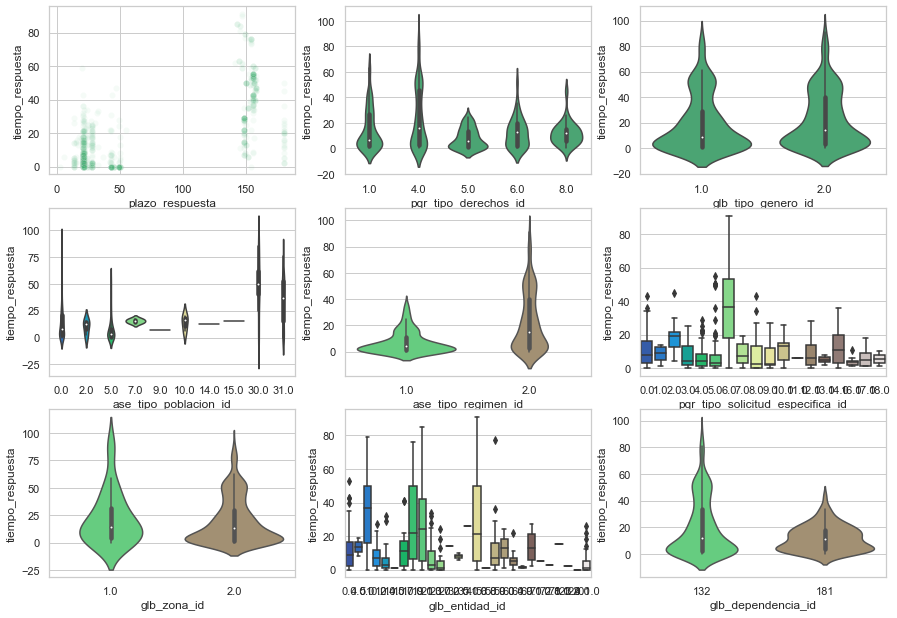

In [11]:
# Create subplots of the dependent variables Vs each independent variable
nr=3 # number of rows in the subplot
fig, ax = plt.subplots(nrows=nr, ncols=3,figsize=(15,3.5*nr))

sns.scatterplot(x='plazo_respuesta',y='tiempo_respuesta',data=df_model,ax=ax[0,0],alpha=0.05,color = 'mediumseagreen')
sns.violinplot(x='pqr_tipo_derechos_id',y='tiempo_respuesta',data=df_model,ax=ax[0,1],alpha=0.02,color = 'mediumseagreen')
sns.violinplot(x='glb_tipo_genero_id',y='tiempo_respuesta',data=df_model,ax=ax[0,2],alpha=0.02,color = 'mediumseagreen')
sns.violinplot(x='ase_tipo_poblacion_id',y='tiempo_respuesta',data=df_model,palette="terrain",ax=ax[1,0]) # I wanted to plot a violin, but it doesn't worth it because there were many x-values so each violin would be too thin.
sns.violinplot(x='ase_tipo_regimen_id', y='tiempo_respuesta',data=df_model,palette="terrain",ax=ax[1,1]) 
sns.boxplot(x='pqr_tipo_solicitud_especifica_id',  y='tiempo_respuesta', data=df_model,palette="terrain",ax=ax[1,2]) 
sns.violinplot(x='glb_zona_id',  y='tiempo_respuesta', data=df_model,palette="terrain",ax=ax[2,0]) 
sns.boxplot(x='glb_entidad_id',  y='tiempo_respuesta', data=df_model,palette="terrain",ax=ax[2,1]) 
sns.violinplot(x='glb_dependencia_id',  y='tiempo_respuesta', data=df_model,palette="terrain",ax=ax[2,2])

In [20]:
df_model = df_model.drop(['glb_tipo_genero_id', 'ase_tipo_regimen_id','glb_zona_id'], axis=1)


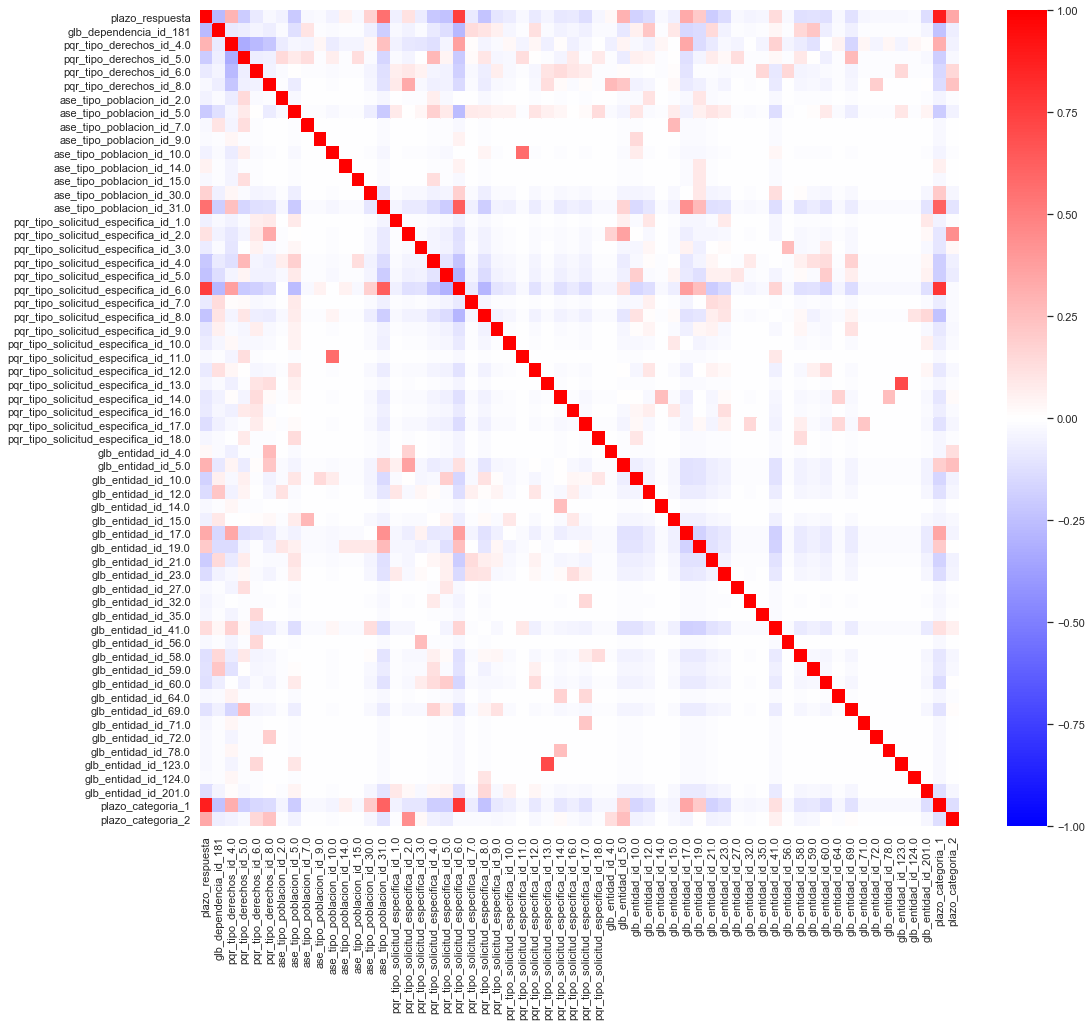

In [21]:

# Look for possible collienarity in the noentidad model
df_model_dropna = df_model.dropna(subset=['glb_entidad_id'])

# Select all the categorical columns of the dataframe
catg_cols = df_model_dropna.select_dtypes(include='category').columns

# Convert all categorial data to one-hot encoding format and calculate the correlation matrix to look 
# for possible collinearity
df_dummy = pd.get_dummies(df_model_dropna.drop(['tiempo_respuesta'], axis=1), columns=catg_cols, drop_first=True)
f, ax = plt.subplots(figsize=(17,15))
ax = sns.heatmap(df_dummy.corr(), cmap = 'bwr', vmin=-1, vmax=1)
# plt.savefig('corr_matrix.pdf',bbox_inches='tight')

In [22]:
cormat = df_dummy.corr()
cormat[cormat<1].max().max()

0.877229825241693

# Regression Model

In [23]:
# Functions to apply the OLS model, plot it and evaluate it
def apply_reg(lista, df=df_model, trans='no'):
    
    '''
    create a OLS model with the vars in "lista" and the data in "df"
    '''
    
    columns_str = " + ".join(lista)
    
    # Create the model and print its summary
    if trans == 'log':
        formula = 'np.log(tiempo_respuesta+1) ~ ' + columns_str 
    elif trans == 'sqrt':
        formula = 'np.sqrt(tiempo_respuesta) ~ ' + columns_str 
    else:
        formula = 'tiempo_respuesta ~ ' + columns_str 
    model = smf.ols(formula = formula, data = df)
    model_fit = model.fit()
    print(model_fit.summary()) 
    print('AIC from model_all is ' + str(int(model_fit.aic))); # print AIC value
    
    return model_fit, formula

def plot_normal_model(model_fit):

    '''
    For a given model "model_fit": 
    - plot the distribution of the residuals
    - plot the Q-Q graph of the reisduals compared to a normal distribution
    '''

    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,4))

    ax[0].hist(model_fit.resid, 
        density=True,     # the histogram integrates to 1 
                          # (so it can be compared to the normal distribution)
        bins=100,         #  draw a histogram with 100 bins of equal width
        label="residuals" # label for legend
        )
    # now plot the normal distribution for comparison
    xx = np.linspace(model_fit.resid.min(), model_fit.resid.max(), num=10000)
    ax[0].plot(xx, scipy.stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(model_fit.scale)),
        label="normal distribution")
    sns.rugplot(model_fit.resid[np.abs(model_fit.resid)>4*np.sqrt(model_fit.scale)],
                color="lightgreen", # otherwise the color was the same as the histogram
                label="outliers",
                ax= ax[0])
    ax[0].legend(loc="upper left");

    sm.qqplot(model_fit.resid, line="s", ax=ax[1]);

def eval_model(model,dfs_name_list = ['train','test'], trans='no'):
    '''
    Calculate MAE, RMSE and MAPE for OLS model applied to different sets of data in the list dfs_name_list
    '''
 
    eval_df = pd.DataFrame()
    for df in dfs_name_list:
        
        true_values =eval(df).tiempo_respuesta
        if trans == 'log':
            prediction = np.exp(model.predict(eval(df)))-1
        elif trans == 'sqrt':
            prediction = model.predict(eval(df))**2
        else:
            prediction = model.predict(eval(df))

        MAE = np.mean(np.abs(prediction-true_values))
        RMSE = np.sqrt(np.mean(np.square(prediction-true_values)))
        MAPE = np.mean(np.abs((prediction-true_values)/true_values)*100)
        eval_serie = pd.Series({'MAE':MAE,'RMSE':RMSE,'MAPE':MAPE})
        eval_df[df] = eval_serie
    return eval_df

def plot_eval_model(model, df_dataset, trans='no'):
    
    if trans == 'log':
        test_result = np.exp(model.predict(df_dataset))-1 # predicted values on dataset
    elif trans == 'sqrt':
        test_result = model.predict(df_dataset)**2 # predicted values on dataset
    else:
        test_result = model.predict(df_dataset) # predicted values on dataset
    
    test_resid  = df_dataset.tiempo_respuesta - test_result # Residuals for Test dataset

    f, ax = plt.subplots(ncols=2, figsize=(15,6))

    ax[0].scatter(df_dataset.tiempo_respuesta, test_result, alpha=0.5, color='c')
    ax[0].plot(np.linspace(-10,80,1000), np.linspace(-10,80,1000), color='gold')
    ax[0].set_xlabel('True values (days)')
    ax[0].set_ylabel('Predicted values (days)')

    ax[1].hist(test_resid, bins=40, color='c')
    ax[1].set_xlabel('Residuals')
    ax[1].set_ylabel('Frequency');

# Check overfitting using test/train datasets

In [91]:
train = df_model.sample(frac=0.8) #random state is a seed value
test = df_model.drop(train.index).sample(frac=1.0)

In [92]:
# List of dependent variables
col_list = list(df_model.columns)#.remove('cost')
col_list.remove('tiempo_respuesta')

## Modelo con todas las variables

In [93]:
# list with the variables for the OLS formula
col_list_all = ['C(%s)'%(x) if x != 'plazo_respuesta' else x for x in col_list ]
# col_list_all.remove('plazo_respuesta')
# col_list_all.remove('C(pqr_tipo_solicitud_especifica_id)')
col_list_all

['C(glb_dependencia_id)',
 'C(pqr_tipo_derechos_id)',
 'C(ase_tipo_poblacion_id)',
 'C(pqr_tipo_solicitud_especifica_id)',
 'C(glb_entidad_id)',
 'plazo_respuesta',
 'C(plazo_categoria)']

In [94]:
model_all_train, form = apply_reg(col_list_all, df = train)

                            OLS Regression Results                            
Dep. Variable:       tiempo_respuesta   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     17.32
Date:                Thu, 07 Jul 2022   Prob (F-statistic):           5.33e-82
Time:                        19:29:45   Log-Likelihood:                -2124.9
No. Observations:                 542   AIC:                             4358.
Df Residuals:                     488   BIC:                             4590.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


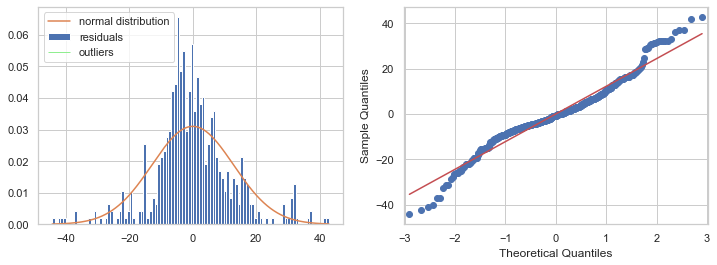

In [95]:
plot_normal_model(model_all_train)

Text(0, 0.5, 'Residuals')

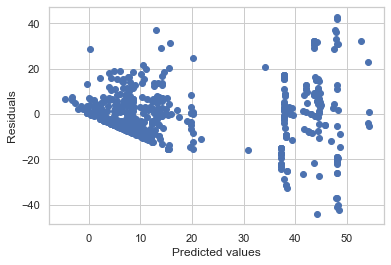

In [96]:
plt.scatter(model_all_train.fittedvalues , model_all_train.resid)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

In [97]:
y, X = dmatrices(form, train, return_type='dataframe')
keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results = het_white(model_all_train.resid, X)
lzip(keys, results)

[('Lagrange Multiplier statistic:', 318.6487105436151),
 ("LM test's p-value:", 0.07689254209698942),
 ('F-statistic:', 1.2910363924639081),
 ("F-test's p-value:", 0.018452849393242553)]

In [98]:
eval_model(model_all_train)

,train,test
MAE,8.694295,10.402964
RMSE,12.201739,13.852745
MAPE,inf,inf


C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


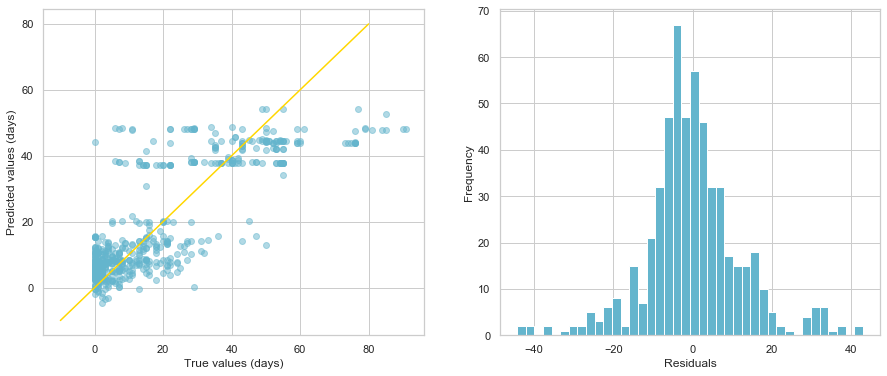

In [99]:
plot_eval_model(model_all_train, train)

C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


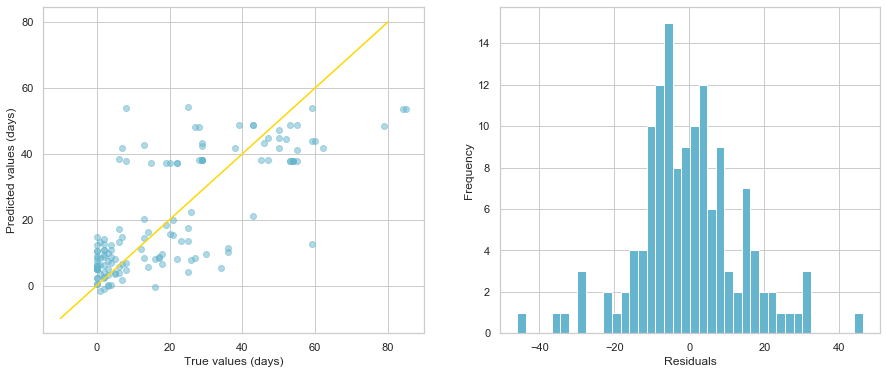

In [100]:
plot_eval_model(model_all_train, test)

## Modelo sin entidad

In [101]:
col_list_noentidad = list(np.copy(col_list_all))
col_list_noentidad.remove('C(glb_entidad_id)')
col_list_noentidad

['C(glb_dependencia_id)',
 'C(pqr_tipo_derechos_id)',
 'C(ase_tipo_poblacion_id)',
 'C(pqr_tipo_solicitud_especifica_id)',
 'plazo_respuesta',
 'C(plazo_categoria)']

In [102]:
model_noentidad_train , form= apply_reg(col_list_noentidad, df=train)

                            OLS Regression Results                            
Dep. Variable:       tiempo_respuesta   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     31.30
Date:                Thu, 07 Jul 2022   Prob (F-statistic):           3.83e-97
Time:                        19:29:51   Log-Likelihood:                -2189.0
No. Observations:                 555   AIC:                             4440.
Df Residuals:                     524   BIC:                             4574.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

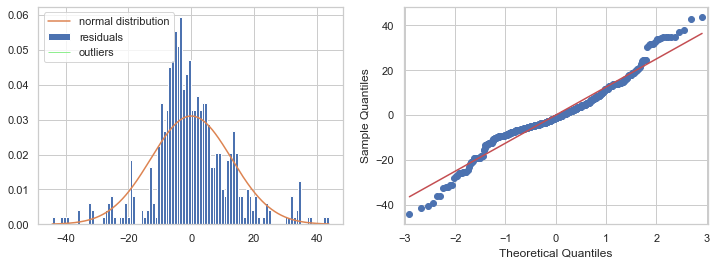

In [103]:
plot_normal_model(model_noentidad_train)

Text(0, 0.5, 'Residuals')

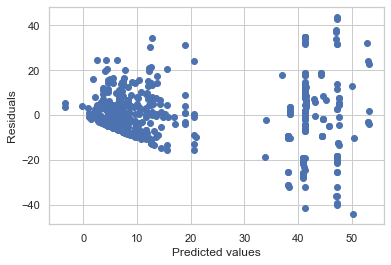

In [104]:
plt.scatter(model_noentidad_train.fittedvalues , model_noentidad_train.resid)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

In [105]:
y, X = dmatrices(form, train, return_type='dataframe')
keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results = het_white(model_noentidad_train.resid, X)
lzip(keys, results)

[('Lagrange Multiplier statistic:', 241.8540868059696),
 ("LM test's p-value:", 1.1178404663276867e-07),
 ('F-statistic:', 2.3282034393308737),
 ("F-test's p-value:", 4.720913183546994e-11)]

In [106]:
eval_model(model_noentidad_train)

,train,test
MAE,9.003756,10.289587
RMSE,12.493316,13.997379
MAPE,inf,inf


C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


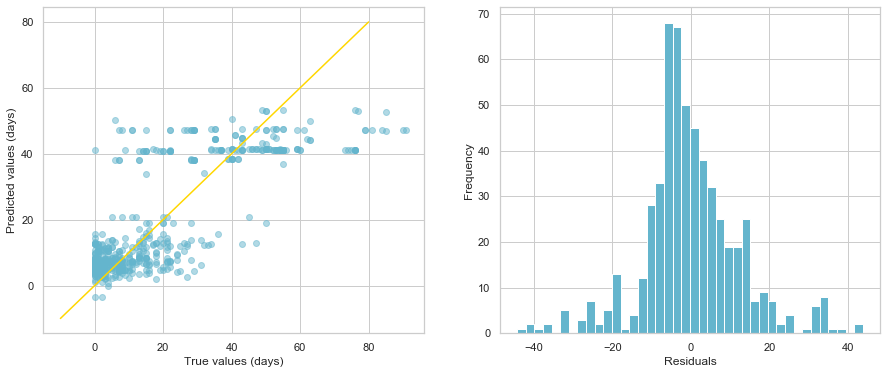

In [107]:
plot_eval_model(model_noentidad_train, train)

C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


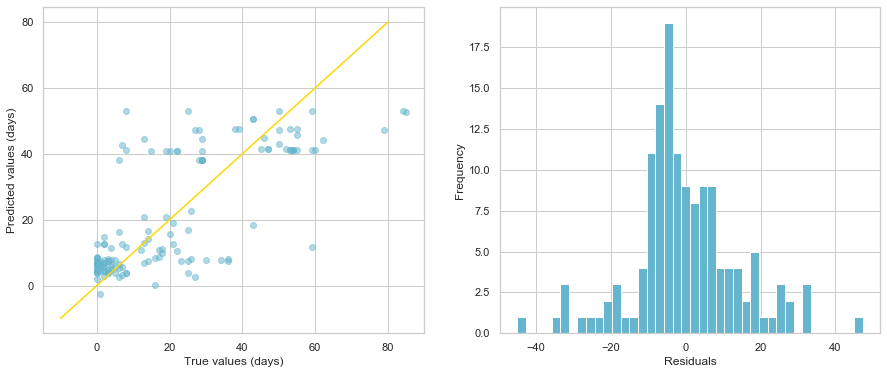

In [108]:
plot_eval_model(model_noentidad_train, test)

## Model sin plazo_respuesta

In [109]:
col_list_plazo2 = list(np.copy(col_list_all))
col_list_plazo2.remove('C(glb_entidad_id)')
col_list_plazo2.remove('plazo_respuesta')
# col_list_plazo2.append('I(plazo_respuesta**2)')
col_list_plazo2

['C(glb_dependencia_id)',
 'C(pqr_tipo_derechos_id)',
 'C(ase_tipo_poblacion_id)',
 'C(pqr_tipo_solicitud_especifica_id)',
 'C(plazo_categoria)']

In [110]:
model_plazo2_train, form = apply_reg(col_list_plazo2, df=train)

                            OLS Regression Results                            
Dep. Variable:       tiempo_respuesta   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     32.41
Date:                Thu, 07 Jul 2022   Prob (F-statistic):           7.67e-98
Time:                        19:29:57   Log-Likelihood:                -2189.1
No. Observations:                 555   AIC:                             4438.
Df Residuals:                     525   BIC:                             4568.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

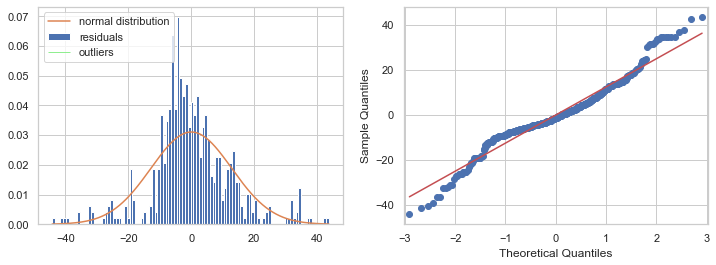

In [111]:
plot_normal_model(model_plazo2_train)

Text(0, 0.5, 'Residuals')

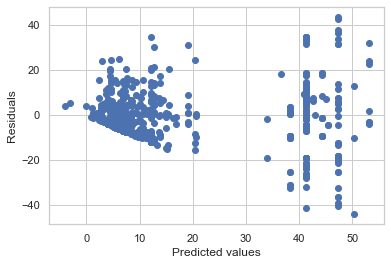

In [112]:
plt.scatter(model_plazo2_train.fittedvalues , model_plazo2_train.resid)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

In [113]:
y, X = dmatrices(form, train, return_type='dataframe')
keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results = het_white(model_plazo2_train.resid, X)
lzip(keys, results)

[('Lagrange Multiplier statistic:', 164.26171975403238),
 ("LM test's p-value:", 0.0017684167415182952),
 ('F-statistic:', 1.604785843433455),
 ("F-test's p-value:", 0.000388938773994144)]

In [114]:
eval_model(model_plazo2_train)

,train,test
MAE,8.995294,10.281305
RMSE,12.496818,13.978459
MAPE,inf,inf


C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


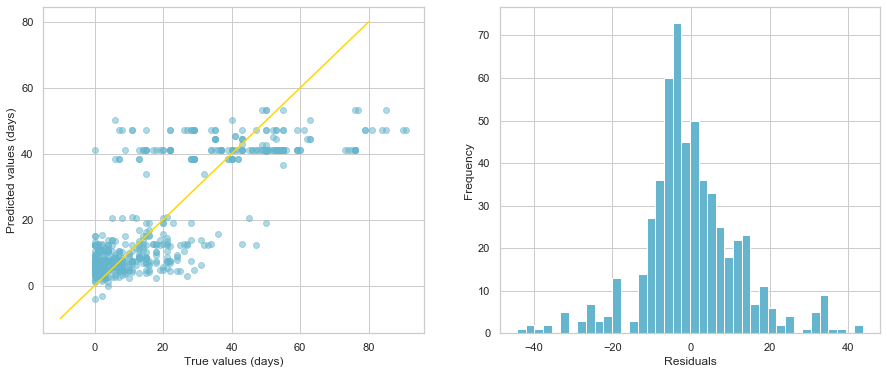

In [115]:
plot_eval_model(model_plazo2_train, train)

C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


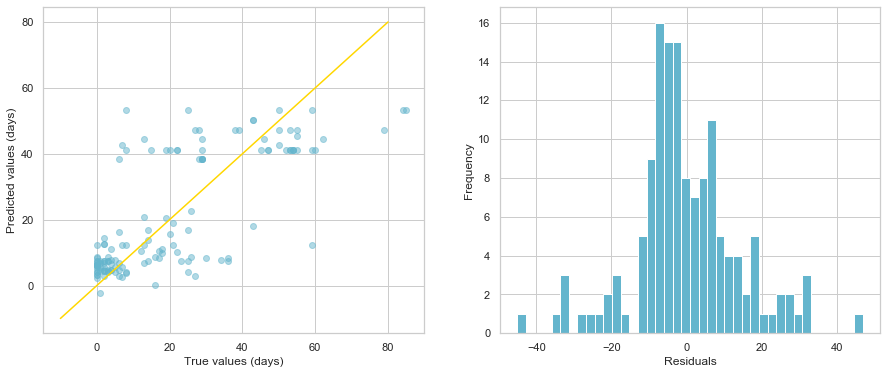

In [116]:
plot_eval_model(model_plazo2_train, test)

## Model using sqrt

In [117]:
col_list_all_sqrt= list(np.copy(col_list_all))
# col_list_plazo_log.append('np.log(plazo_respuesta)')
col_list_all_sqrt

['C(glb_dependencia_id)',
 'C(pqr_tipo_derechos_id)',
 'C(ase_tipo_poblacion_id)',
 'C(pqr_tipo_solicitud_especifica_id)',
 'C(glb_entidad_id)',
 'plazo_respuesta',
 'C(plazo_categoria)']

In [118]:
model_all_sqrt, form = apply_reg(col_list_all_sqrt, df = train, trans='sqrt')

                                OLS Regression Results                               
Dep. Variable:     np.sqrt(tiempo_respuesta)   R-squared:                       0.653
Model:                                   OLS   Adj. R-squared:                  0.615
Method:                        Least Squares   F-statistic:                     17.30
Date:                       Thu, 07 Jul 2022   Prob (F-statistic):           6.46e-82
Time:                               19:30:03   Log-Likelihood:                -979.30
No. Observations:                        542   AIC:                             2067.
Df Residuals:                            488   BIC:                             2299.
Df Model:                                 53                                         
Covariance Type:                   nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


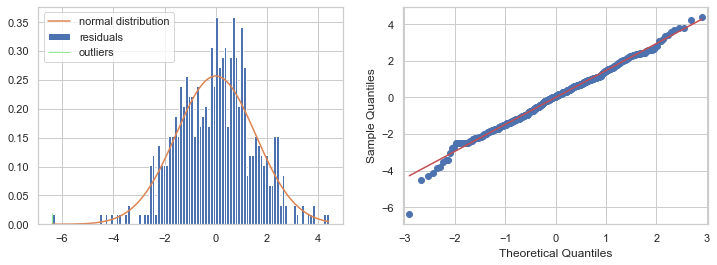

In [119]:
plot_normal_model(model_all_sqrt)

Text(0, 0.5, 'Residuals')

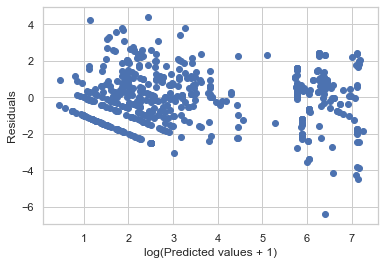

In [120]:
plt.scatter(model_all_sqrt.fittedvalues, model_all_sqrt.resid)
plt.xlabel('log(Predicted values + 1)')
plt.ylabel('Residuals')

In [121]:
y, X = dmatrices(form, train, return_type='dataframe')
keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results = het_white(model_all_sqrt.resid, X)
lzip(keys, results)

[('Lagrange Multiplier statistic:', 271.9328883691355),
 ("LM test's p-value:", 0.6863750996003628),
 ('F-statistic:', 0.911181344091282),
 ("F-test's p-value:", 0.7780755861133557)]

In [122]:
eval_model(model_all_sqrt, trans='sqrt')

,train,test
MAE,8.656808,10.286354
RMSE,12.721326,14.488244
MAPE,inf,inf


C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


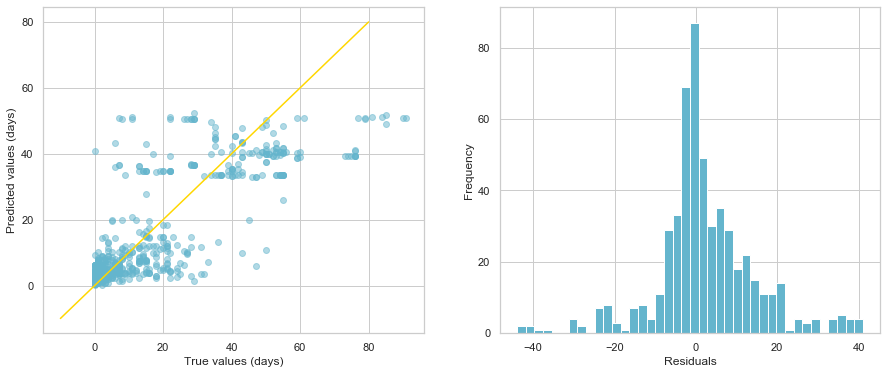

In [123]:
plot_eval_model(model_all_sqrt, train, trans='sqrt')

C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


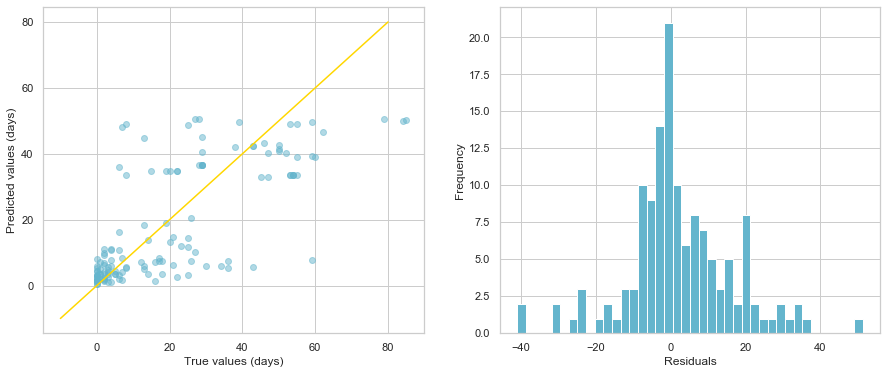

In [124]:
plot_eval_model(model_all_sqrt, test, trans='sqrt')

## Model using sqrt sin plazo respuesta

In [125]:
col_list_plazo_sqrt_noplazo = list(np.copy(col_list_all))
col_list_plazo_sqrt_noplazo.remove('plazo_respuesta')
# col_list_plazo_log_noplazo.remove('C(glb_entidad_id)')

# col_list_plazo_log_noplazo.append('np.log(plazo_respuesta)')
col_list_plazo_sqrt_noplazo

['C(glb_dependencia_id)',
 'C(pqr_tipo_derechos_id)',
 'C(ase_tipo_poblacion_id)',
 'C(pqr_tipo_solicitud_especifica_id)',
 'C(glb_entidad_id)',
 'C(plazo_categoria)']

In [126]:
model_plazo_sqrt_noplazo, formula = apply_reg(col_list_plazo_sqrt_noplazo, df = train, trans='sqrt')

                                OLS Regression Results                               
Dep. Variable:     np.sqrt(tiempo_respuesta)   R-squared:                       0.651
Model:                                   OLS   Adj. R-squared:                  0.614
Method:                        Least Squares   F-statistic:                     17.53
Date:                       Thu, 07 Jul 2022   Prob (F-statistic):           5.04e-82
Time:                               19:30:09   Log-Likelihood:                -980.70
No. Observations:                        542   AIC:                             2067.
Df Residuals:                            489   BIC:                             2295.
Df Model:                                 52                                         
Covariance Type:                   nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


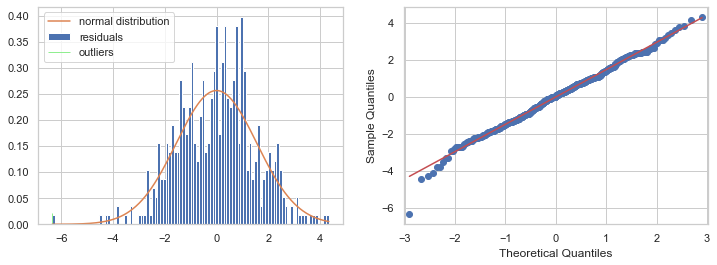

In [127]:
plot_normal_model(model_plazo_sqrt_noplazo)

Text(0, 0.5, 'Residuals')

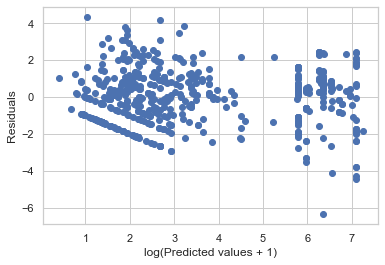

In [128]:
plt.scatter(model_plazo_sqrt_noplazo.fittedvalues, model_plazo_sqrt_noplazo.resid)
plt.xlabel('log(Predicted values + 1)')
plt.ylabel('Residuals')

In [129]:
y, X = dmatrices(formula, train, return_type='dataframe')
keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results = het_white(model_plazo_sqrt_noplazo.resid, X)
lzip(keys, results)

[('Lagrange Multiplier statistic:', 237.0023742558376),
 ("LM test's p-value:", 0.7128434900970992),
 ('F-statistic:', 0.9045013480373792),
 ("F-test's p-value:", 0.7933126561684763)]

In [130]:
eval_model(model_plazo_sqrt_noplazo, trans = 'sqrt')

,train,test
MAE,8.604032,10.236907
RMSE,12.638364,14.466808
MAPE,inf,inf


C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


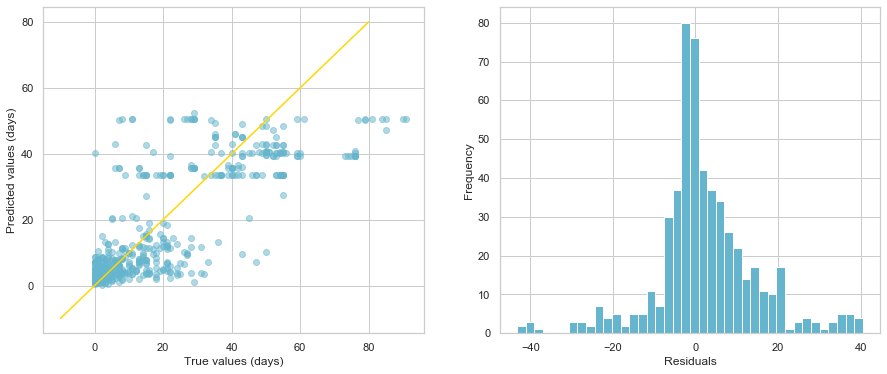

In [131]:
plot_eval_model(model_plazo_sqrt_noplazo, train, trans='sqrt')

C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


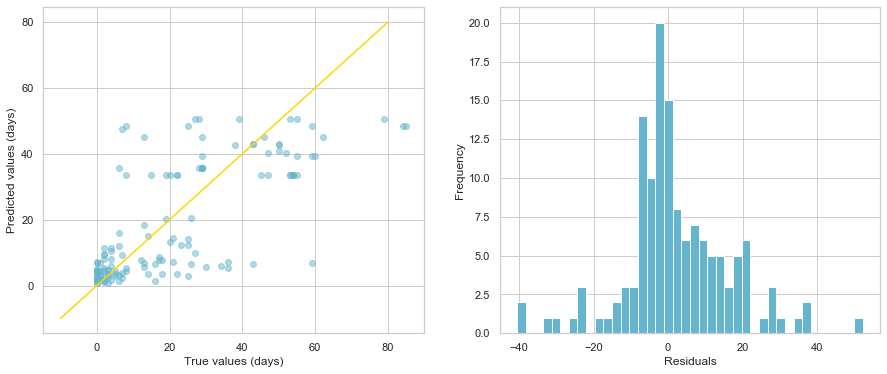

In [132]:
plot_eval_model(model_plazo_sqrt_noplazo, test, trans='sqrt')

## Removing the variables that showed high correlations

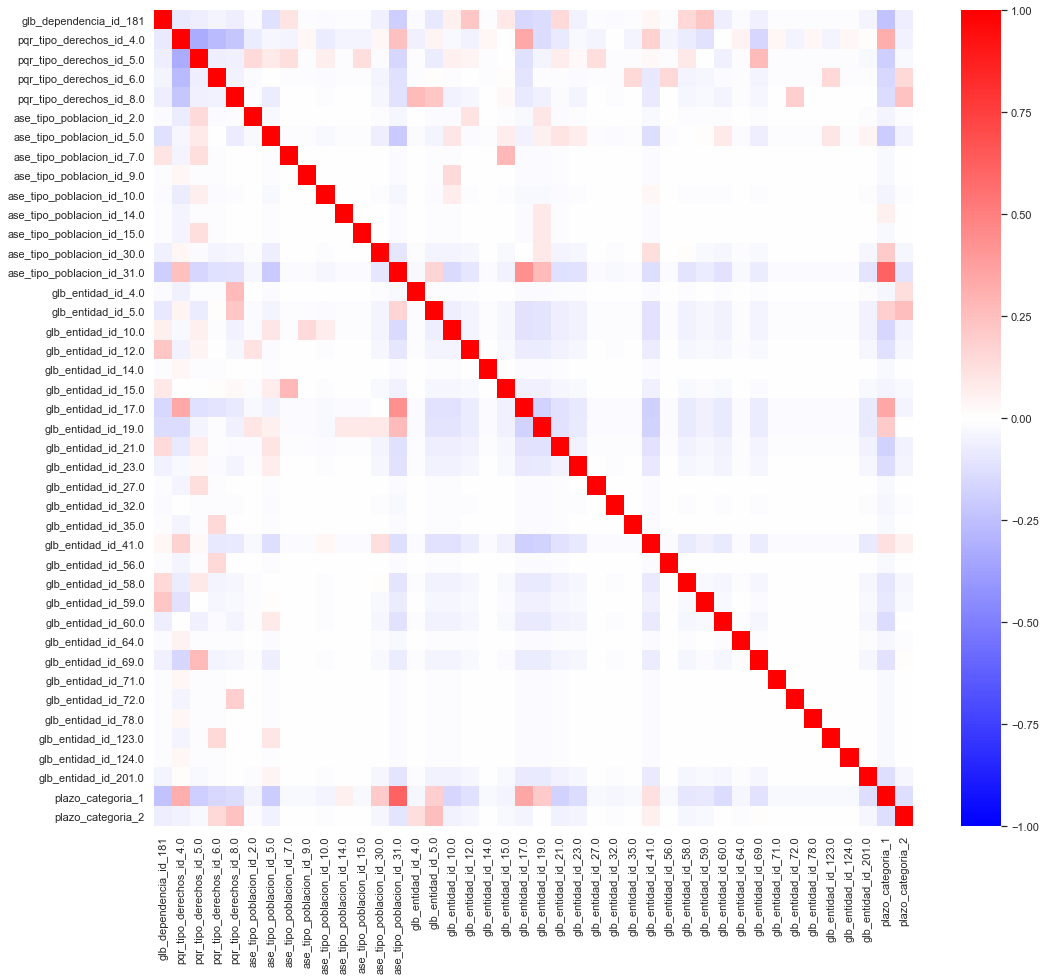

In [133]:
# Remove the variables that showed high correlation and calculate the new corr matrix
df_model_dropna = df_model.dropna(subset=['glb_entidad_id'])
df_model_dropna = df_model_dropna.drop(['plazo_respuesta','pqr_tipo_solicitud_especifica_id'], axis=1)
# Select all the categorical columns of the dataframe
catg_cols = df_model_dropna.select_dtypes(include='category').columns

# Convert all categorial data to one-hot encoding format and calculate the correlation matrix to look 
# for possible collinearity
df_dummy = pd.get_dummies(df_model_dropna.drop(['tiempo_respuesta'], axis=1), columns=catg_cols, drop_first=True)
f, ax = plt.subplots(figsize=(17,15))
ax = sns.heatmap(df_dummy.corr(), cmap = 'bwr', vmin=-1, vmax=1)

## ******* Model using sqrt sin plazo respuesta ni solicitud espicifica *******

In [134]:
col_list_plazo_sqrt_noplazo_nosol = list(np.copy(col_list_all))
col_list_plazo_sqrt_noplazo_nosol.remove('plazo_respuesta')
col_list_plazo_sqrt_noplazo_nosol.remove('C(pqr_tipo_solicitud_especifica_id)')

# col_list_plazo_log_noplazo.remove('C(glb_entidad_id)')

# col_list_plazo_log_noplazo.append('np.log(plazo_respuesta)')
col_list_plazo_sqrt_noplazo_nosol

['C(glb_dependencia_id)',
 'C(pqr_tipo_derechos_id)',
 'C(ase_tipo_poblacion_id)',
 'C(glb_entidad_id)',
 'C(plazo_categoria)']

In [135]:
formula

'np.sqrt(tiempo_respuesta) ~ C(glb_dependencia_id) + C(pqr_tipo_derechos_id) + C(ase_tipo_poblacion_id) + C(pqr_tipo_solicitud_especifica_id) + C(glb_entidad_id) + C(plazo_categoria)'

In [136]:
model_plazo_sqrt_noplazo_nosol, formula = apply_reg(col_list_plazo_sqrt_noplazo_nosol, df = train, trans='sqrt')

                                OLS Regression Results                               
Dep. Variable:     np.sqrt(tiempo_respuesta)   R-squared:                       0.640
Model:                                   OLS   Adj. R-squared:                  0.614
Method:                        Least Squares   F-statistic:                     24.91
Date:                       Thu, 07 Jul 2022   Prob (F-statistic):           2.03e-89
Time:                               19:30:18   Log-Likelihood:                -989.19
No. Observations:                        542   AIC:                             2052.
Df Residuals:                            505   BIC:                             2211.
Df Model:                                 36                                         
Covariance Type:                   nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


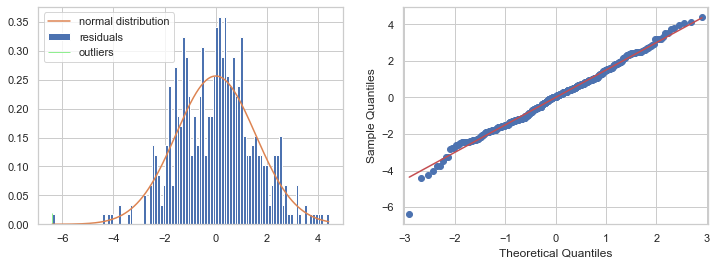

In [137]:
plot_normal_model(model_plazo_sqrt_noplazo_nosol)

Text(0, 0.5, 'Residuals')

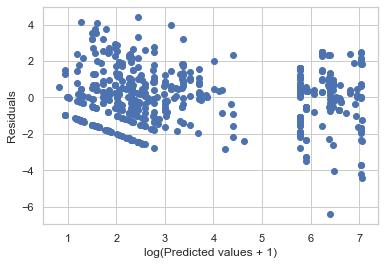

In [138]:
plt.scatter(model_plazo_sqrt_noplazo_nosol.fittedvalues, model_plazo_sqrt_noplazo_nosol.resid)
plt.xlabel('log(Predicted values + 1)')
plt.ylabel('Residuals')

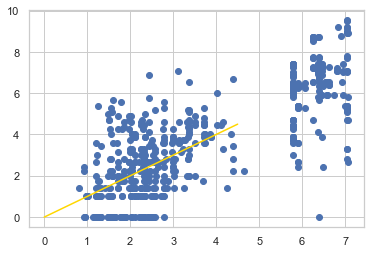

In [139]:
# plt.scatter(model_plazo_log_noplazo.fittedvalues, np.log(train.dropna().tiempo_respuesta+1))
plt.scatter(model_plazo_sqrt_noplazo_nosol.fittedvalues, np.sqrt(train.dropna().tiempo_respuesta))
plt.plot(np.linspace(0,4.5,1000), np.linspace(0,4.5,1000), color='gold')



In [140]:
y, X = dmatrices(formula, train, return_type='dataframe')

keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results = het_white(model_plazo_sqrt_noplazo_nosol.resid, X)
lzip(keys, results)

[('Lagrange Multiplier statistic:', 143.24451023166708),
 ("LM test's p-value:", 0.25677293796979883),
 ('F-statistic:', 1.101995532361877),
 ("F-test's p-value:", 0.23680905741465913)]

In [141]:
eval_model(model_plazo_sqrt_noplazo_nosol, trans = 'sqrt')

,train,test
MAE,8.610606,10.197112
RMSE,12.673871,14.443501
MAPE,inf,inf


C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


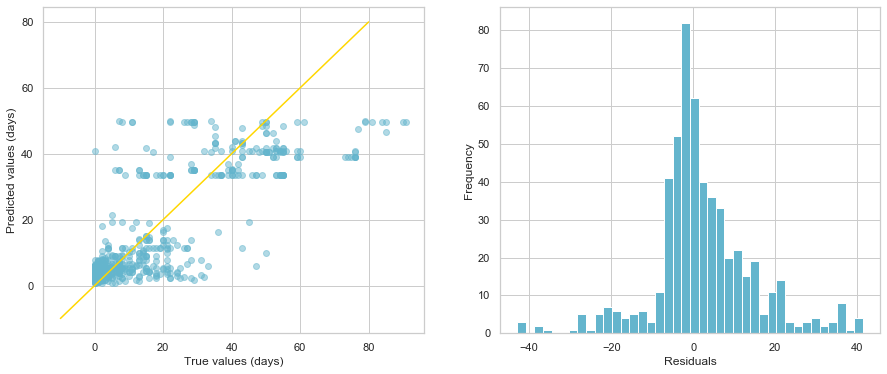

In [142]:
plot_eval_model(model_plazo_sqrt_noplazo_nosol, train, trans='sqrt')

C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


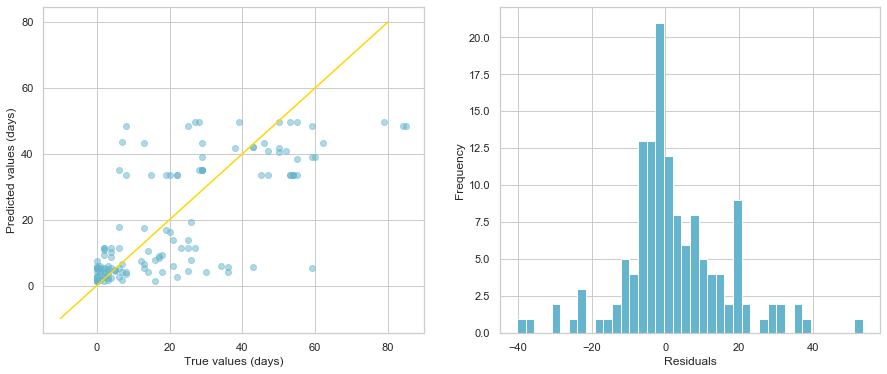

In [143]:
plot_eval_model(model_plazo_sqrt_noplazo_nosol, test, trans='sqrt')

In [144]:
model_plazo_sqrt_noplazo_nosol.save('LR_model_PQRS.pickle')

## Model using log-log sin entidad

In [145]:
col_list_plazo_log_noent = list(np.copy(col_list_all))
# col_list_plazo_log_noent.remove('C(glb_entidad_id)')
# col_list_plazo100.remove('plazo_respuesta')
# col_list_plazo_log_noent.append('np.log(plazo_respuesta)')
col_list_plazo_log_noent

['C(glb_dependencia_id)',
 'C(pqr_tipo_derechos_id)',
 'C(ase_tipo_poblacion_id)',
 'C(pqr_tipo_solicitud_especifica_id)',
 'C(glb_entidad_id)',
 'plazo_respuesta',
 'C(plazo_categoria)']

In [146]:
model_plazo_log_noent, form = apply_reg(col_list_plazo_log_noent, df = train, trans='log')

                                 OLS Regression Results                                 
Dep. Variable:     np.log(tiempo_respuesta + 1)   R-squared:                       0.610
Model:                                      OLS   Adj. R-squared:                  0.568
Method:                           Least Squares   F-statistic:                     14.40
Date:                          Thu, 07 Jul 2022   Prob (F-statistic):           2.30e-70
Time:                                  19:30:24   Log-Likelihood:                -677.44
No. Observations:                           542   AIC:                             1463.
Df Residuals:                               488   BIC:                             1695.
Df Model:                                    53                                         
Covariance Type:                      nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975

C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


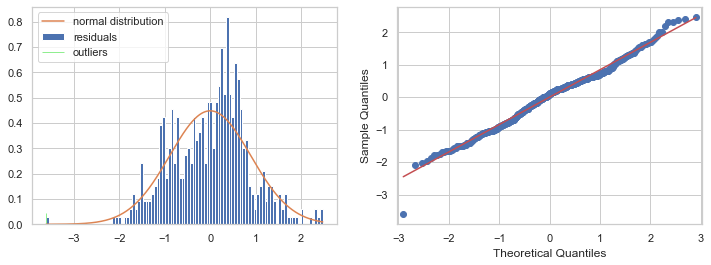

In [147]:
plot_normal_model(model_plazo_log_noent)

Text(0, 0.5, 'Residuals')

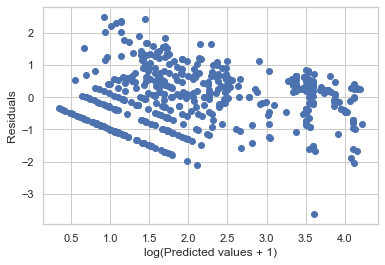

In [148]:
plt.scatter(model_plazo_log_noent.fittedvalues, model_plazo_log_noent.resid)
plt.xlabel('log(Predicted values + 1)')
plt.ylabel('Residuals')

In [149]:
y, X = dmatrices(form, train, return_type='dataframe')

keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results = het_white(model_plazo_log_noent.resid, X)
lzip(keys, results)

[('Lagrange Multiplier statistic:', 317.07787987037966),
 ("LM test's p-value:", 0.08610502848046052),
 ('F-statistic:', 1.2757000142501635),
 ("F-test's p-value:", 0.02332156375941763)]

In [150]:
eval_model(model_plazo_log_noent,trans='log')

,train,test
MAE,9.685926,11.073923
RMSE,14.291039,16.141128
MAPE,inf,inf


C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


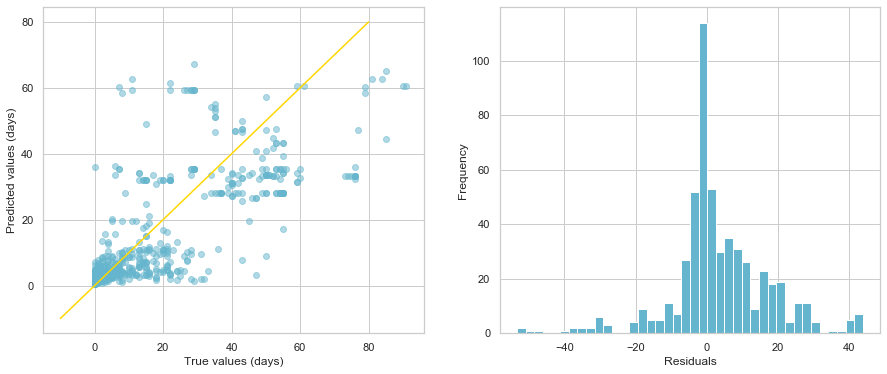

In [151]:
plot_eval_model(model_plazo_log_noent, train, trans='log')

C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


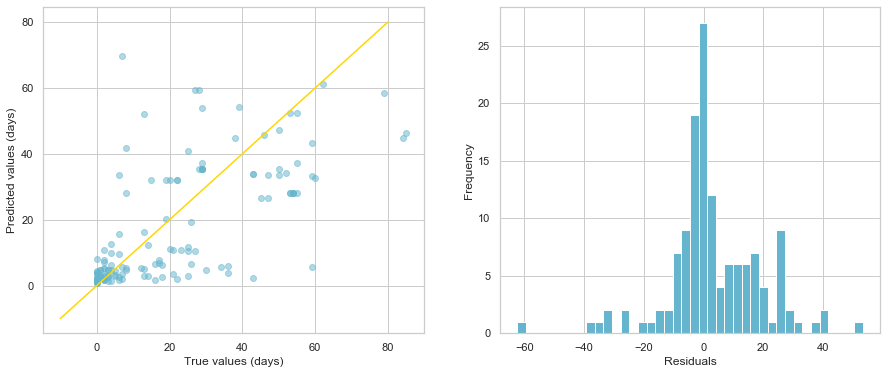

In [152]:
plot_eval_model(model_plazo_log_noent, test, trans='log')

# Aplicacion del modelo elegido

In [153]:
# llamar datos de BD: obtener fila de datos de las columnas necesarias
# Hacer la limpieza de datos a df_model
# aplicar la funcion model.predict()

In [154]:
model_plazo_log_noent.save('model_example.pickle')

In [156]:
ols_model = sm.load('model_example.pickle')

In [157]:
input_instance = df_model[['glb_dependencia_id',
 'pqr_tipo_derechos_id',
 'ase_tipo_poblacion_id',
 'pqr_tipo_solicitud_especifica_id',
 'glb_entidad_id',
 'plazo_respuesta', #fecha_respuesta - fecha_radicacion
 'plazo_categoria' # fecha_vencimiento - fecha_radicacion
            ]]

In [158]:
a =train.loc[[train.index[0]]]

In [159]:
a

,glb_dependencia_id,pqr_tipo_derechos_id,ase_tipo_poblacion_id,pqr_tipo_solicitud_especifica_id,glb_entidad_id,plazo_respuesta,tiempo_respuesta,plazo_categoria
id,,,,,,,,
732,181,NaN,0.0,0.0,59.0,21,20,0


In [160]:
ols_model.predict(a)

id
732   NaN
dtype: float64